# State-space analysis

## Context

In this tutorial, we will explore a powerful tool for studying dynamical systems: state-space analysis. This method has been widely applied in various scientific studies. Specifically, we will cover:

- Quantifying short-time predictability through the Lyapunov exponent
- State-space reconstruction using delay embedding
- The maximum predictability principle for determining optimal embedding parameters


These techniques have been successfully used to analyze animal behavior, as demonstrated by Ahamed et al. [1]. 


<img src= "fig/worm_state_space.png" alt="processed image" align="middle" width="800"/>



### Key words
dynamical system, state space, delay-embedding, state space reconstruction, Lyapunov exponent, Maximally predictive state space. 

### References


(1) Ahamed, T.; Costa, A. C.; Stephens, G. J. Capturing the Continuous Complexity of Behaviour in Caenorhabditis Elegans. Nat. Phys. 2021, 17 (2), 275–283. https://doi.org/10.1038/s41567-020-01036-8.

(2) Abarbanel, H. D. I. Analysis of Observed Chaotic Data; Institute for Nonlinear Science; Springer New York: New York, NY, 1996. https://doi.org/10.1007/978-1-4612-0763-4.

(3) Strogatz, Steven H. Nonlinear Dynamics and Chaos: With Applications to Physics, Biology, Chemistry, and Engineering. Second edition. Boulder, CO: Westview Press, a member of the Perseus Books Group, 2015.

(4) Costa, A.C., Ahamed, T., Jordan, D., Stephens, G.J., 2023. Maximally predictive states: From partial observations to long timescales. Chaos 33, 023136. https://doi.org/10.1063/5.0129398


## Import libraries
Your environment should have:

* numpy
* matplotlib
* scipy
* scikit-learn
* plotly
* ipywidgets

In [1]:
# import libraries

import sys
sys.path.append('./lib')

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import plotly.graph_objs as go
import plotly
from sklearn.cluster import MiniBatchKMeans
plt.rcParams.update({'font.size': 16})
import warnings
warnings.filterwarnings("ignore")


## State space

In this tutorial, we use the Lorenz system as a toy model dynamical system. Our goal is to help build intuition before applying the technique to real biological data, which can be more noisy and complex. 

<span style="font-size: medium;">&#x2753;</span> **What is the Lorenz system**

The Lorenz system is a set of three differential equations originally developed to model atmospheric convection, and it is known for its chaotic behavior, leading to the famous "butterfly effect." It serves as a common toy model in dynamical systems research because, despite its simple formulation (only three equations!), it exhibits complex, non-linear behavior that is easy to visualize and study.  Here are the equations that govern it: 


\begin{align}
\frac{\mathrm{d}x}{\mathrm{d}t} &= \sigma (y - x), \\[6pt]
\frac{\mathrm{d}y}{\mathrm{d}t} &= x (\rho - z) - y, \\[6pt]
\frac{\mathrm{d}z}{\mathrm{d}t} &= x y - \beta z.
\end{align}

Let's simulate its dynamics to get a sense of its complexity. Using these equations, we will start to plot the position of the $x$, $y$ and $z$ coordinates. 


In [2]:
def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]
dt = 0.02
frameRate=1/dt
T = 500#*2 
state0 = np.array([-10,-22,27])
t = np.linspace(0, T, int(T*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)

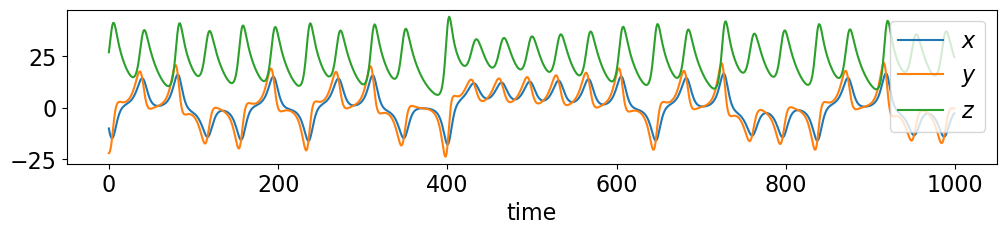

In [3]:
plt.figure(figsize=[12,2])
plt.plot(tseries[:1000])
plt.xlabel('time')
plt.legend(['$x$','$y$','$z$'])
plt.show()

Even with just these three simple equations, the system exhibits surprisingly complex and unpredictable behavior, making it difficult to discern any clear structure at first glance. This is a hallmark of chaotic systems. However, let's explore what happens when we plot the variables against each other in different dimensions

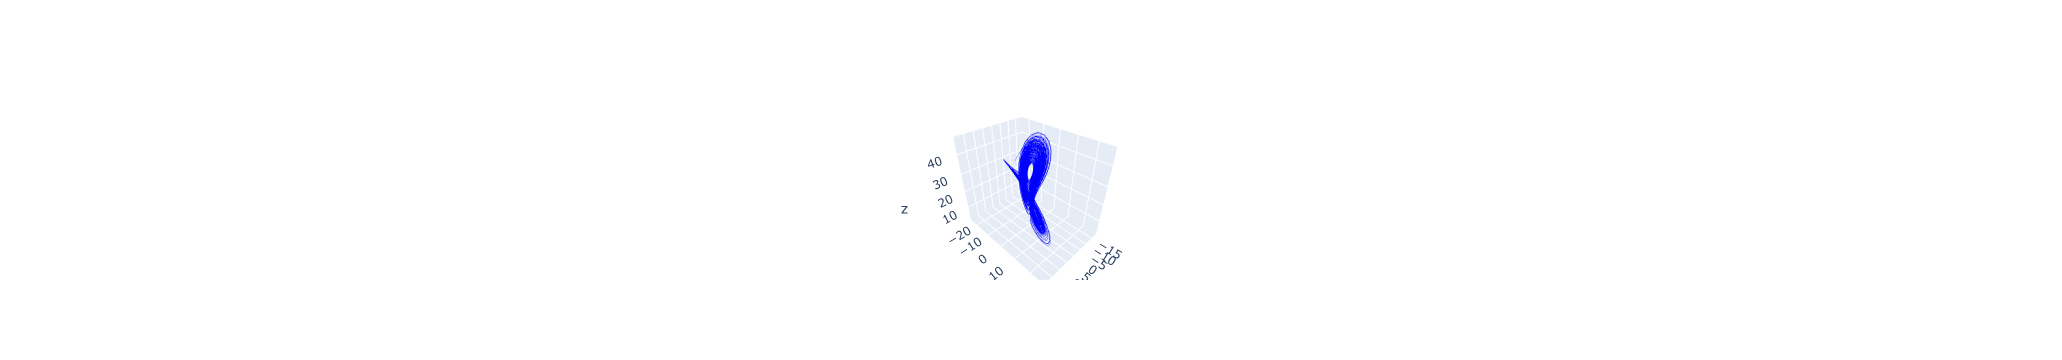

In [4]:

# Create an interactive 3D plot
fig = go.Figure(data=[go.Scatter3d(
    x=tseries[:10**4, 0],
    y=tseries[:10**4, 1],
    z=tseries[:10**4, 2],
    mode='lines',
    line=dict(width=0.5, color='blue')
)])

# Add labels to the axes
fig.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z'
    )
)

# Render the plot inline using the iframe renderer
plotly.offline.iplot(fig) #for VSCode
#plot_figure.show(renderer="iframe") #for jupyter notebook


&#x2757;   Take a moment to observe and play around with this surprising butterfly shape !

Since the system has 3 dimensions in total, this plot represents the complete state space of the system. 
In general, the state space of a dynamical system is the set of all possible states of a dynamical system, or all the states the system can occupy; by specifying a point in state space, we can identify a particular state of the system. To be clearer: at every point in time, the system is somewhere is in the state space. 

For example, the initial state of the simulation was $x=-10$, $y=-22$, $z=27$. Where is it in the state space? Let's plot this initial point on the state space. 

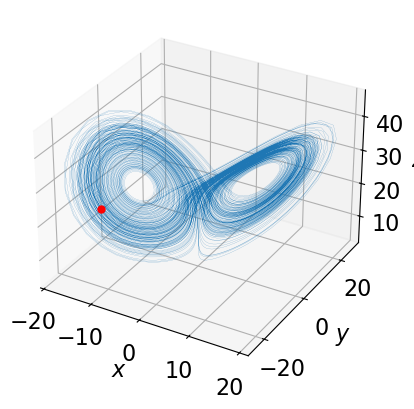

In [5]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*tseries.T[:,:10**4], lw=0.1)
ax.plot(-10,-22,27, 'r.', ms=10)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
plt.show()

# A look into chaos

The Lorenz system is one of the most famous model of chaos. One of the defining property of chaotic system is the sensitive dependence on initial conditions. 

Let's examine this sensitive dependence on initial conditions with the Lorenz system. We consider two initial conditions (1) $x=-10$, $y=-22$, $z=27$ (the blue point) (2) $x=-10-\epsilon$, $y=-22$, $z=27$ (the red point), where $\epsilon=10^{-10}$. Notice that the difference between two points, $\epsilon$, is very small.

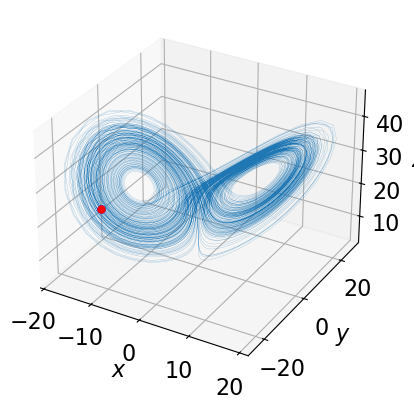

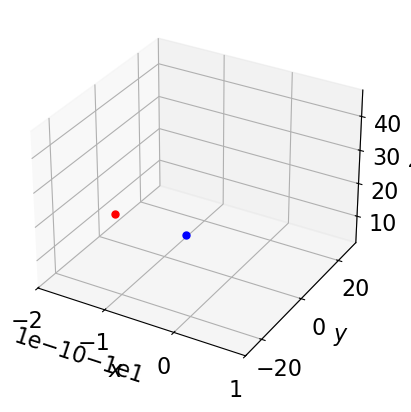

In [6]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*tseries.T[:,:10**4], lw=0.1)
ax.plot(-10,-22,27, 'b.', ms=10)
ax.plot(-10-10**-10,-22,27, 'r.', ms=10)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
plt.show()
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*tseries.T[:,:10**4], lw=0.1)
ax.plot(-10,-22,27, 'b.', ms=10)
ax.plot(-10-10**-10,-22,27, 'r.', ms=10)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
# ax.set_ylim([-23,-21])
ax.set_xlim([-10-2*10**-10,-10+10**-10])
plt.show()

Let's simulate dynamics from these two almost identical initial consitions and look at the time series of them. 

In [7]:
initial_1 = np.array([-10,-22,27])
tseries_1=np.array(odeint(Lorenz,initial_1,t,args=(sigma,rho,beta)),dtype=np.float64)

initial_2 = np.array([-10+10**-10,-22,27])
tseries_2=np.array(odeint(Lorenz,initial_2,t,args=(sigma,rho,beta)),dtype=np.float64)

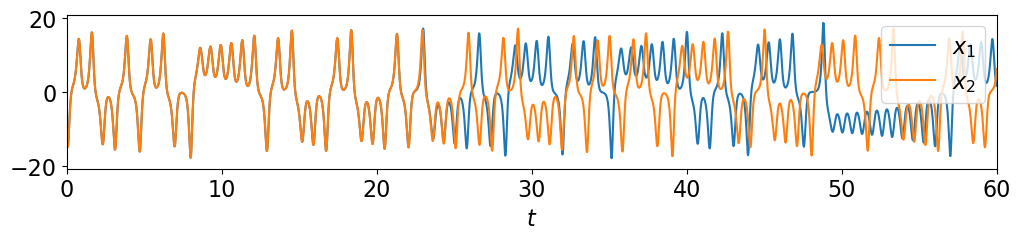

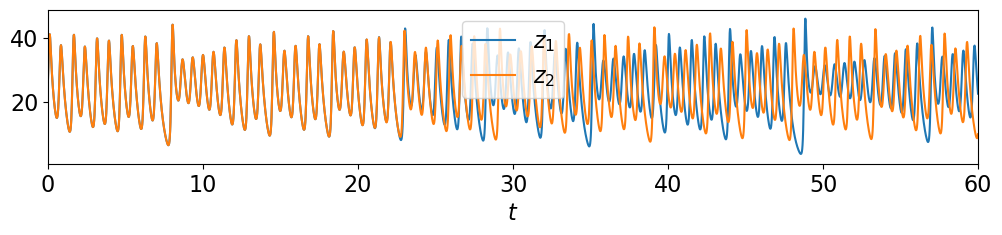

In [8]:
plt.figure(figsize=[12,2])
plt.plot(t,tseries_1[:,0])
plt.plot(t,tseries_2[:,0])
plt.xlabel('$t$')
plt.xlim([0,60])
plt.legend(['$x_1$','$x_2$'])
plt.show()

plt.figure(figsize=[12,2])
plt.plot(t,tseries_1[:,2])
plt.plot(t,tseries_2[:,2])
plt.xlabel('$t$')
plt.xlim([0,60])
plt.legend(['$z_1$','$z_2$'])
plt.show()

The orange time-series is from the red initial point (1) and the blue is from the blue initial point (2). The two trajectories are very similar at the beginning, but widely separate the end. How did this difference between two trajectories, or error, of the dynamics grow?  Let's look closely at how the error, $\delta(t)=||s_1(t)-s_2(t)||$, evolved over time, where $s_i(t)=[x_i(t),y_i(t),z_i(t)]$ is the state vector at time $t$.

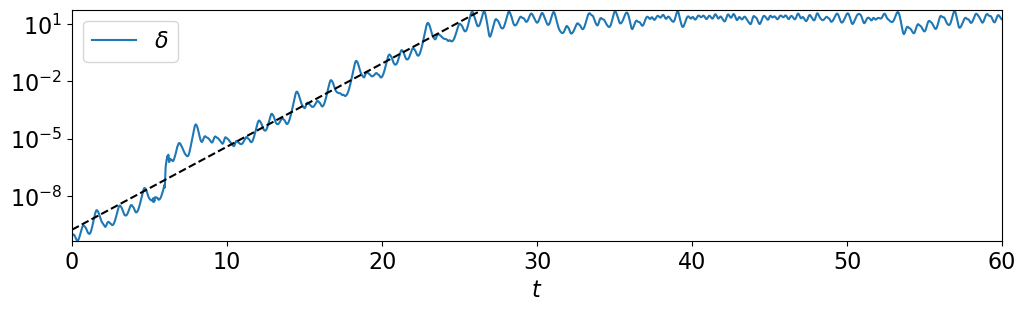

In [9]:
plt.figure(figsize=[12,3])
delta = np.linalg.norm(tseries_1-tseries_2,axis=1)
plt.plot(t,delta)
idx = np.arange(np.min(np.where(delta>10.)))
m, b = np.polyfit(t[idx], np.log(delta)[idx], 1)
y_fit = m * t + b
plt.plot(t,np.exp(y_fit),c='k',ls='--')
plt.xlim([0,60])
plt.ylim([np.min(delta),np.max(delta)])
plt.xlabel('$t$')
plt.yscale('log')
plt.legend(['$\delta $'])
plt.show()

The error grows exponentially (the y-axis is in log scale). This continuous, exponentially fast separation of neighboring states is the defining feature of chaotic dynamics. In an equation,

$$\delta(t) \sim \delta(0)e^{\lambda t}.$$

Therefore, chaotic dynamics are not random (allowing short-term prediction up to a certain point) but are also not completely stereotyped (as error grows in the future), and thus they show a delicate balance between order and disorder. 

## An experiment of neighbor states divergence
A natural question is: how fast is the separation of two trajectories, and how typical is it? The exponent $\lambda$ in the above equation can measure how fast the error grows or shrinks. When $\lambda$ is positive, it measures the rate of separation, whereas, when it is negative, it measures how fast two trajectories are converging into one. In the above demonstration, we picked one example of initial conditions. However, the rate of separation $\lambda$ can depend on the choice of the initial conditions. 

We can estimate the average $\lambda$ from multiple pairs of trajectories to know the average rate of error growth. We perform such estimation by doing following steps;
1. Simulate a long trajectory from the Lorenz system.
2. Randomly select a short trajectory in the simulation and find another trajectory whose initial point is closest to that of the first trajectory (we find a pair of trajectories whose initial points are very close). 
3. Compute the error dynamics $\delta(t)=||s_1(t)-s_2(t)||$ between these two trajectories and find the exponent $\lambda$ by perfoming an exponential fit.
4. Repeat 2 and 3, and estimate the average exponent $\bar \lambda$.

In [10]:
# simulate a long trajectory
T = 50000
state0 = np.array([-10,-22,27])
t = np.linspace(0, T, int(T*frameRate))
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)

In [11]:
# a function that find a pair of closest trajectories
def neighbor_states(tseries,n_trials=200,l=500):
    series_1,series_2 = [],[]
    np.random.seed(0)
    for i in range(n_trials):
        idx = np.random.randint(tseries.shape[0]-l)
        series_1.append(tseries[idx:idx+l])
        if tseries.ndim == 1:
            distances = np.abs(tseries - series_1[i][0])
        else:
            distances = np.linalg.norm(tseries - series_1[i][0], axis=1)
        distances[idx:idx+l] = np.nan
        closest_index = np.nanargmin(distances) # Find the index of the closest point
        series_2.append(tseries[closest_index:closest_index+l]) 
    return series_1,series_2

In [12]:
tseries_1,tseries_2 = neighbor_states(tseries)
deltas = [np.linalg.norm(tseries_1[i]-tseries_2[i],axis=1) for i in range(len(tseries_1))]

We sampled 200 pairs of short trajectories from the simulation and calculated the error between each pairs. For examples, let's look at the error dynamics from three trials.

trial #1


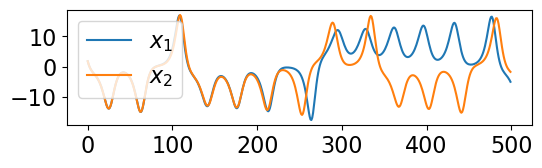

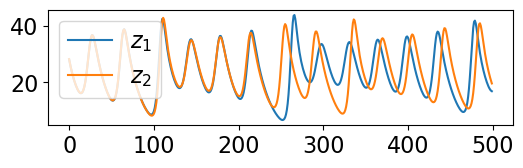

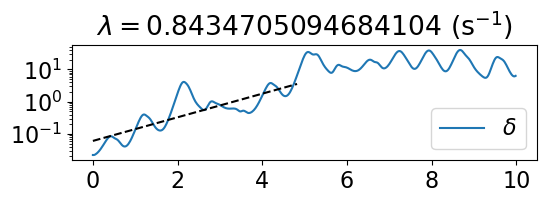

trial #2


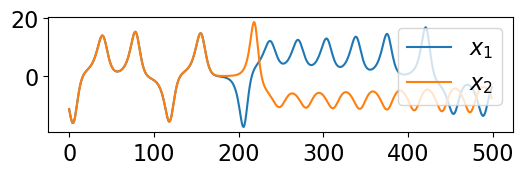

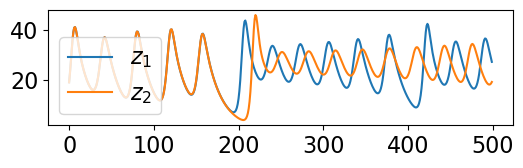

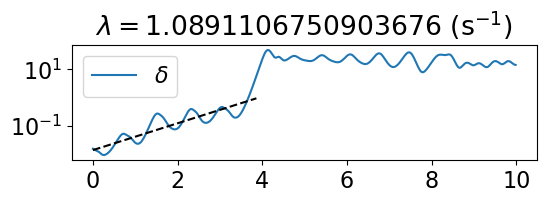

trial #3


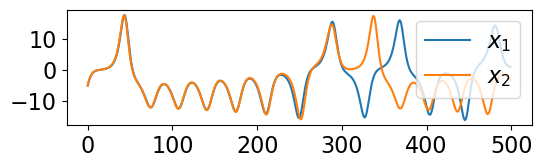

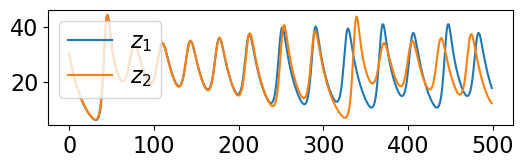

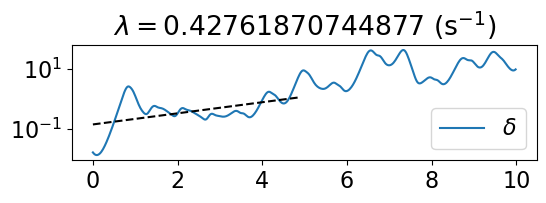

In [13]:
for i in range(3):
    print("trial #"+str(i+1))
    plt.figure(figsize=[12*.5,3*.5])
    plt.plot(tseries_1[i].T[0])
    plt.plot(tseries_2[i].T[0])
    # plt.xlabel('$t$')
    # plt.xlim([0,40])
    plt.legend(['$x_1$','$x_2$'])
    plt.show()
    
    plt.figure(figsize=[12*.5,3*.5])
    plt.plot(tseries_1[i].T[2])
    plt.plot(tseries_2[i].T[2])
    # plt.xlabel('$t$')
    # plt.xlim([0,40])
    plt.legend(['$z_1$','$z_2$'])
    plt.show()

    plt.figure(figsize=[12*.5,3*.5])
    plt.semilogy(t[:len(deltas[i])],deltas[i])
    # plt.plot(t[:len(deltas[i])],np.log(deltas[i]))
    # plt.xlabel('$t$')
    # plt.xlim([0,40])
    plt.legend(['$\delta$'])
    th = np.mean(deltas)
    idx = np.arange(np.min(np.where(deltas[i]>th)))
    m, b = np.polyfit(t[idx], np.log(deltas[i])[idx], 1)
    y_fit = m * t[idx] + b
    plt.plot(t[idx],np.exp(y_fit),c='k',ls='--')
    plt.title('$\lambda = $'+str(m)+' (s$^{-1}$)')
    plt.show()
    

Here, we compute the average exponent from all 200 trials.

In [14]:
def average_exponents(deltas):
    exponents = []
    th = np.mean(deltas)
    for i in range(len(deltas)):
        try:
            idx = np.arange(np.min(np.where(deltas[i]>th)))
        except:
            idx = np.arange(len(deltas[i]))
        m, b = np.polyfit(t[idx], np.log(deltas[i])[idx], 1)
        y_fit = m * t[idx] + b
        exponents.append(m)
    return exponents

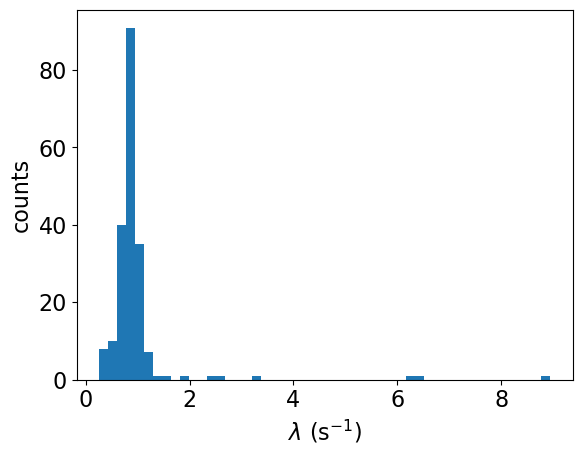

0.9734218487335101


In [15]:
exponents = average_exponents(deltas)
plt.hist(exponents,bins=50)
plt.ylabel('counts')
plt.xlabel('$\lambda$ (s$^{-1}$)')
plt.show()

print(np.mean(exponents))

The mean exponent should be around $\bar \lambda=$0.9 (s$^{-1}$). In fact, this whole set of calculation of $\bar \lambda$ is a rough estimate of the largest Lyapunov exponent, which is the fastest component of the error dynamics in the system. The largest Lyapunov exponent being positive implies that almost identical states will diverge in the future. Thus, it is one of the definition of the sensitive dependence on initial conditions i.e. chaos in dynamical system theory. 

The largest Lyapunov exponent for the Lorenz system is known to be about 0.91 (s$^{-1}$). So the Lorenz system is a chaotic system. Also, notice that our rough estimate was not bad. 

The largest Lyapunov exponent is a good proxy of short-time (un)predictability. It has a nice property such that the exponent does not change under the change of coordinate (called an invariant property). This is ideal because the exponent won't be affected by how you look at the system. This is a subtle but very interesting aspect of the Lyapunov exponent. For an introduction to chaos and Lyapunov exponent, please refer to reference (1), and (2) and (3) for a more precise and complete estimation of Lyapunov exponent.

For simplicity, we will refer to the largest Lyapunov exponent simply as the Lyapunov exponent in the following. 

# Incomplete data and delay-embedding

At every time point of the dynamics, the system state maps to a single point in the state space. Measurements ($x$, $y$, $z$ positions) are a function of the state space projected onto the real numbers line, so they only provide indirect information about its properties. To deepen our intuition about this, let us watch this video by Sugihara et al., Detecting Causality in Complex Ecosystems, Science, 2012. that illustrates it with the Lorenz system.

<div align="center">
<video src="fig/vid_intro_state_space_Sugihara.mp4" align="middle" width="500" controls>  </video>
</div>


As you might have noticed, having a complete state space is highly advantageous! It allows patterns in the system's dynamics to be clearly represented, which significantly aids in predicting behavior and analyzing the system.

The shape of the state space reveals important properties of the system. For example, in the Lorenz system, we can immediately observe attracting states forming the batterfly shape object, known as attractor, around which the system revolves. In general, analyzing the geometry and topology of the state space provides valuable insights into the behavior of dynamical systems. For example, we can investigate (unstable) periodic orbits in the attractor as a skeleton of complex dynamics [1]. 

In the case of the Lorenz system, we know the governing equations and that the system has three dimensions. However, in real-world experiments, obtaining a complete state space is rarely possible due to measurement noise and incomplete data. Imagine a mouse brain consists of more than 10 million neurons, however we can only measure part of them simultaneously with some measurement noize. 

To illustrate such problem, let's simulate an experimental scenario where we only measure the $x$ variable, discarding the $y$ and $z$ time series from the Lorenz system. We now have a real-life scenario with incomplete measurements.

<span style="font-size: medium;">&#x2753;</span> **Can we recover the complete state space of the Lorenz system with 1-dimensional, incomplete data?** 

We can, and the second part of this tutorial will how you do that, using a technique called delay embedding. First, let's take only the $x$ part of our time series. 

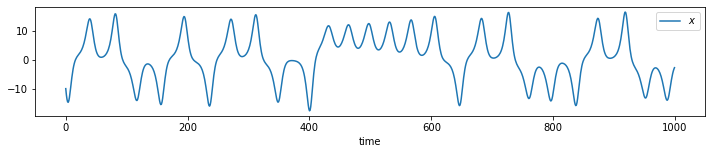

In [17]:
x = tseries[:,0] # take only x
plt.figure(figsize=[12,2])
plt.plot(x[:1000])
plt.xlabel('time')
plt.legend(['$x$'])
plt.show()

We can think that the information of $y$ and $z$ might be encoded in the dynamics of $x$ because the time evolution of $x$ is influenced by $y$ (and the dynamics of $y$ is influenced by $z$, see the equation of motion of the Lorenz system). Let's introduce $x^{'}$ and $x^{"}$, which are delayed versions of $x$. 

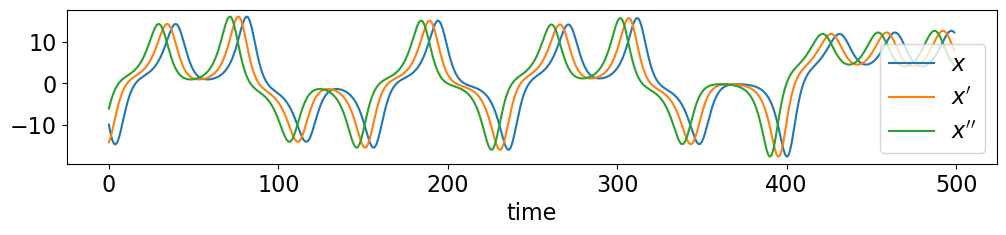

In [23]:
x_prime = x[5:] 
x_doubleprime = x[10:] 
plt.figure(figsize=[12,2])
plt.plot(x[:500])
plt.plot(x_prime[:500])
plt.plot(x_doubleprime[:500])
plt.xlabel('time')
plt.legend(['$x$','$x^\prime$', '$x^{\prime \prime}$'])
plt.show()

Now, let's look at the state space created by these three variables, just like we did with $x$, $y$, and $z$. 

In [19]:
# Create an interactive 3D plot
fig = go.Figure(data=[go.Scatter3d(
    x=x[:10**4],
    y=x_prime[:10**4],
    z=x_doubleprime[:10**4],
    mode='lines',
    line=dict(width=0.5, color='blue')
)])

# Add labels to the axes using Unicode for prime and double prime
fig.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='x\u2032',        # Unicode for x'
        zaxis_title='x\u2033'         # Unicode for x''
    )
)

# Render the plot inline using the iframe renderer
plotly.offline.iplot(fig) #for VSCode
#fig.show(renderer="iframe") #for jupyter notebook


&#x2757; Take a moment to look at this state space created from $x$, and two delayed versions of $x$. 


You may notice that the trajectory in the new state space has a similar structure as one in the original state space. In fact, they are related and topologically equivalent, so, roughly speaking, the new space is a deformed copy of the original space!

This trick was the first discovered in fluid mechanics and called delay-embedding. 


In mathematical terms, delay-embedding is the augmentation of a time series $x(t)$ into a higher dimension through the construction of a delay vector: 

$$\vec{x}(t) = (x(t), x(t-d),...,x(t-Kd)). $$

We call parameters $K$ and $d$ delay and interval, respectively. We will set $d = 1$ for the purposes of this tutorial and will only treat $K$, the delay parameter. 


The Takens theorem guarantees that we will be able to create a smooth and one-to-one map between the original state space and reconstructed state space $\vec{x}$ that will conserve its topological properties. 

The following video summrizes the idea of delay embedding. More detailed discussion and history of delay embedding can be found in [2].

<div align="center">
<video src="fig/vid_Takens_thm_Sugihara.mp4" align="middle" width="500" controls>  </video>
</div>


<span style="font-size: medium;">&#x2753;</span> **How much information can we recover using this technique?**
[Note to instructors: You may skip this section to "Choosing Embedding Parameters."]

To answer this question, let's go back to the experiment of neighbour states divergence. As we saw before, two nearby points in state space of the Lorenz system separates exponentially fast and the rate of separation can be measured by the Lyapunov exponent. 

Let's first examine the Lyapunov exponent of the incomplete time series $\{x(t)\}$.

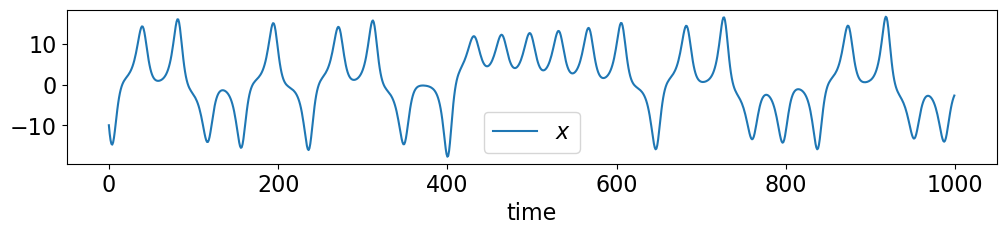

In [16]:
x = tseries[:,0] # take only x
plt.figure(figsize=[12,2])
plt.plot(x[:1000])
plt.xlabel('time')
plt.legend(['$x$'])
plt.show()

In [17]:
tseries_1,tseries_2 = neighbor_states(x)
deltas = [np.abs(tseries_1[i]-tseries_2[i]) for i in range(len(tseries_1))]

Here are three examples of error dynamics of a pair of trajectories starting from the closest states within the simulation. Some of the pairs deviate immediately and give high exponent $\lambda$.

trial #1


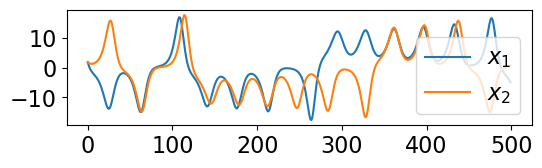

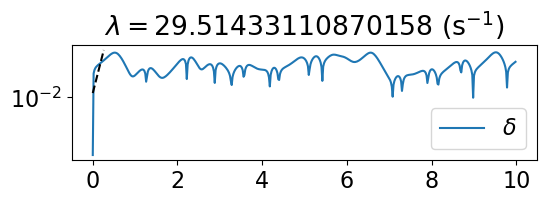

trial #2


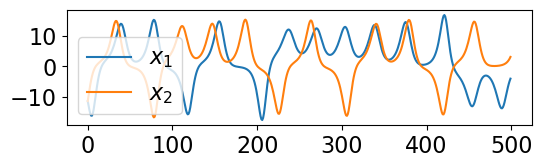

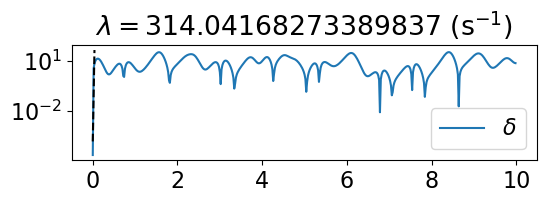

trial #3


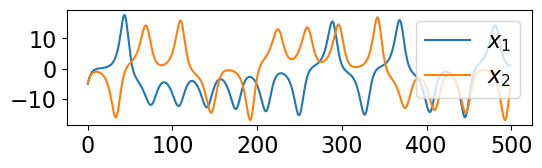

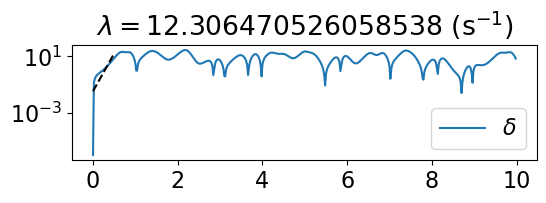

In [18]:
for i in range(3):
    print("trial #"+str(i+1))
    plt.figure(figsize=[12*.5,3*.5])
    plt.plot(tseries_1[i])
    plt.plot(tseries_2[i])
    # plt.xlabel('$t$')
    # plt.xlim([0,40])
    plt.legend(['$x_1$','$x_2$'])
    plt.show()

    plt.figure(figsize=[12*.5,3*.5])
    plt.semilogy(t[:len(deltas[i])],deltas[i])
    # plt.plot(t[:len(deltas[i])],np.log(deltas[i]))
    # plt.xlabel('$t$')
    # plt.xlim([0,40])
    plt.legend(['$\delta$'])
    th = np.mean(deltas)
    idx = np.arange(np.min(np.where(deltas[i]>th)))
    m, b = np.polyfit(t[idx], np.log(deltas[i])[idx], 1)
    y_fit = m * t[idx] + b
    plt.plot(t[idx],np.exp(y_fit),c='k',ls='--')
    plt.title('$\lambda = $'+str(m)+' (s$^{-1}$)')
    plt.show()
    

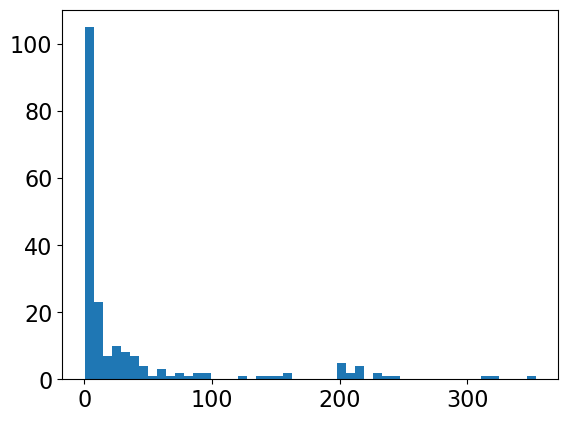

38.001190875582324


In [22]:
plt.hist(exponents,bins=50)
plt.show()

exponents = average_exponents(deltas)
print(np.mean(exponents))

Previously with complete data $\{x(t),y(t),z(t)\}$, the average exponent was 0.88 (s$^{-1}$). On the other hand, with the incomplete data $\{x(t)\}$, now the average exponent is much higher. This implies that nearby points in the incomplete state space will separate faster than those in complete state spaces, suggesting the incomplete data is more difficult to forecast. This might be intuitive because nearby points in incomplete state space may not be neighbor points in true state space. For example, two very distant points in true state space $\{x=-10$, $y=-22$, $z=27\}$ and $\{x=-10$, $y=10$, $z=5\}$ will collapse into the same point $\{x=-10\}$ in the incomplete state space.  

Next, let's examine the Lyapunov exponent of the reconstructed time series $\{x(t), x'(t), x''(t)\}$.

In [24]:
le = len(x_doubleprime)
tseries_reconstructed = np.array([x[:le],x_prime[:le],x_doubleprime]).T

In [25]:
tseries_1,tseries_2 = neighbor_states(tseries_reconstructed)
deltas = [np.linalg.norm(tseries_1[i]-tseries_2[i],axis=1) for i in range(len(tseries_1))]

trial #1


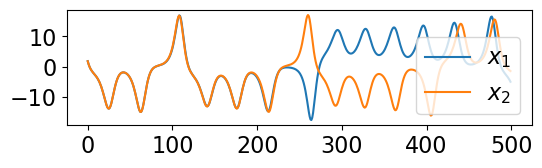

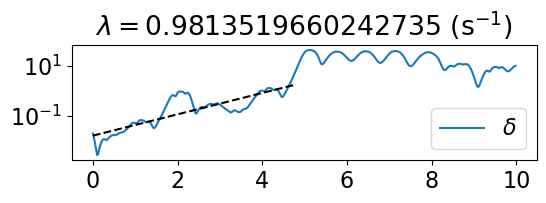

trial #2


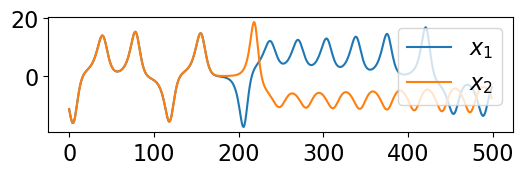

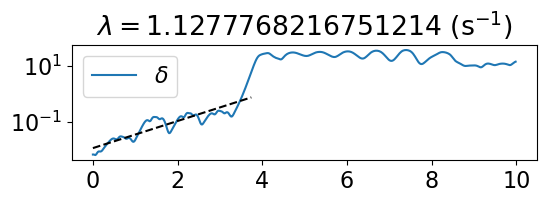

trial #3


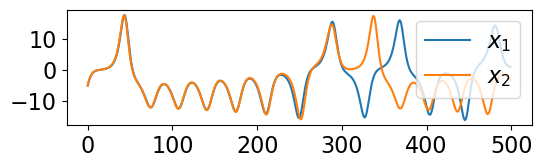

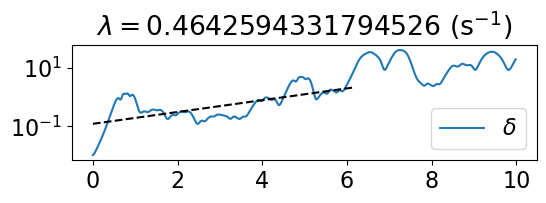

In [26]:
for i in range(3):
    print("trial #"+str(i+1))
    plt.figure(figsize=[12*.5,3*.5])
    plt.plot(tseries_1[i].T[0])
    plt.plot(tseries_2[i].T[0])
    # plt.xlabel('$t$')
    # plt.xlim([0,40])
    plt.legend(['$x_1$','$x_2$'])
    plt.show()
    

    plt.figure(figsize=[12*.5,3*.5])
    plt.semilogy(t[:len(deltas[i])],deltas[i])
    # plt.plot(t[:len(deltas[i])],np.log(deltas[i]))
    # plt.xlabel('$t$')
    # plt.xlim([0,40])
    plt.legend(['$\delta$'])
    th = np.mean(deltas)
    idx = np.arange(np.min(np.where(deltas[i]>th)))
    m, b = np.polyfit(t[idx], np.log(deltas[i])[idx], 1)
    y_fit = m * t[idx] + b
    plt.plot(t[idx],np.exp(y_fit),c='k',ls='--')
    plt.title('$\lambda = $'+str(m)+' (s$^{-1}$)')
    plt.show()
    

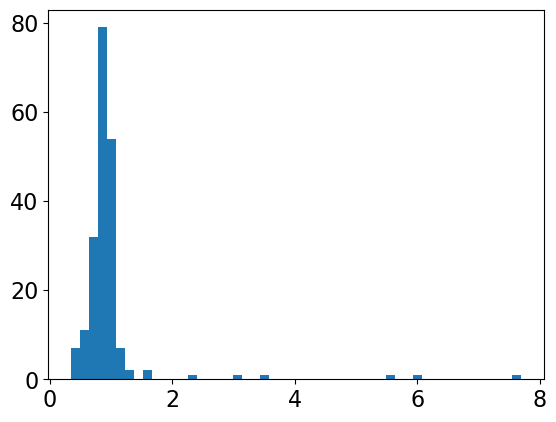

0.971169885823739


In [27]:
exponents = average_exponents(deltas)

plt.hist(exponents,bins=50)
plt.show()
print(np.mean(exponents))

Now, the average exponent is back to a value close to the exponent in the complete state space. Let's summarize the experiment of neighbor states divergence with three different scenarios. 

|   | complete | incomplete | reconstructed |
|----------|----------|----------|---------|
| $\bar \lambda$  | $\approx 0.9$ | $\approx 40$ | $\approx 0.9$|

In summary, delay embedding allows us to reconstruct missing information in incomplete data, namely the relationships between adjacent state space points, i.e. the state space topology, and recover the short-time predictability.   


### Choosing the embedding parameter 

A nuance we have yet to fully address is the choice of the delay parameter $K$. In our example with the Lorenz system, we arbitrarily delayed $x$ by 4 time steps. However, the impact of $K$ should not be understated. It plays a crucial role in shaping the reconstructed state space and influences the quality of the information we recover from the system. 


Let's explore different values of $K$ with our Lorenz system and observe how it affects the reconstructed state space.

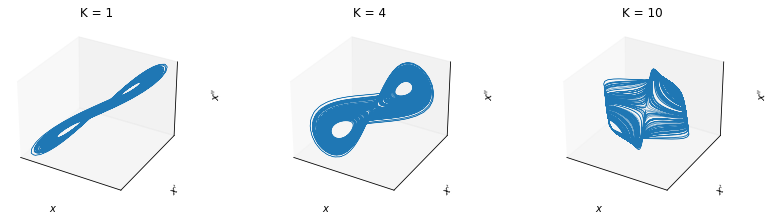

In [28]:
# Initialize the figure
fig = plt.figure(figsize=(12, 3))

# Create subplots for each of the three values of K
K_values = [1, 4, 10]

for i, K in enumerate(K_values, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    
    # Compute x', x'' for the current K
    x_prime = x[K:]           # x' for each K
    x_doubleprime = x[2*K:]    # x'' for each K
    
    # Plot the series for the current K
    ax.plot(x[:10**4], x_prime[:10**4], x_doubleprime[:10**4], lw=0.5)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Add labels to the axes
    ax.set_xlabel("$x$")
    ax.set_ylabel("$x^\prime$")
    ax.set_zlabel("$x^{\prime \prime}$")
    
    # Add entropy to the title
    ax.set_title(f"K = {K}")

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

The relationship between $K$, state space is complex, but we can clearly see that changing $K$ affects the shape of the reconstructed state space. 

<span style="font-size: medium;">&#x2753;</span> **Is there a way to choose $K$ in a principled manner?**

Choosing $K$ is a difficult question, and there is no clear answer. Takens states in his theorem that for a dynamical system of shape $d$, you can embed the state space in $K$ dimensions as long as 

$$ K > 2d $$

However, usually, we don't know what $d$ is. We want a systematic way to determine optimal delay parameter $K^*$. But how can we do that?

A key observation is that, as we saw before, a more complete state space produces better predictability. Inspired by this, we may find the value of $K^*$ that maximizes predictability.

To quantify (un)predictability, we will use a metric from information theory called entropy rate $h$. The entropy rate measures the amount of information you gain from the future signal given the past. We can think about entropy rate as the amount of "surprise" contained in the future outcome. A time-series with low entropy has low surprise and good predictive power. The opposite is true of high entropy. Therefore, the entropy rate quantifies unpredictability of a time-series. The entropy rate is robust to both deterministic and stochastic processes, which is ideal for applying to real data [4].  

The entropy rate is difined as

$$h=-\Sigma_{i,j}^N \pi_i P_{ij} \log{P_{ij}},$$

where $P_{ij}=p(s_j^\mathrm{future}|s_i^\mathrm{past})$ is a transition probability among N discrete state $s_i$, and $\pi$ is the stationary distribution of $P$. The key step in introducing the entropy rate is to introduce the discrete states $s_i$. We find the discrete states by partitioning the state space, i.e., dividing the space into small tiles. There is an optimal way to partition state space [4], but we will cover it in the Markov chain tutorial. Here, we use a k-means clustering method with a reasonable number of clusters to partition the state space.  



In [35]:
def compute_transition_matrix(time_series):
    # Get unique states in the time series
    states = np.unique(time_series)
    num_states = len(states)
    
    # Initialize the transition matrix
    transition_matrix = np.zeros((num_states, num_states), dtype=float)
    
    # Create a mapping from state to index
    state_to_index = {state: index for index, state in enumerate(states)}
    
    # Count transitions
    for (current_state, next_state) in zip(time_series[:-1], time_series[1:]):
        current_index = state_to_index[current_state]
        next_index = state_to_index[next_state]
        transition_matrix[current_index, next_index] += 1
    
    # Normalize rows to get probabilities
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(transition_matrix, row_sums, where=row_sums!=0)
    
    return transition_matrix
    
def compute_stationary_distribution(transition_matrix):
    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    
    # Find the eigenvector associated with eigenvalue 1
    stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]
    
    # Normalize the vector to get probabilities
    stationary_distribution = stationary_vector[:, 0].real
    stationary_distribution /= stationary_distribution.sum()
    
    return stationary_distribution

def perform_kmeans_clustering(data, n_clusters, max_iters=100):
    # Randomly initialize the centroids
    np.random.seed(0)
    centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    
    for _ in range(max_iters):
        # Assign clusters based on closest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Calculate new centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    return labels, centroids
    
def entropy_rate(x,N=100):
    if len(x.shape)==1:
        x = x.reshape(-1,1)
    kmeans = MiniBatchKMeans(n_clusters=N, random_state=0).fit(x)
    labels = kmeans.labels_
#     labels,centers = perform_kmeans_clustering(x,N) # clustering without sk-learn but it's slow
    tm = compute_transition_matrix(labels)
    sd = compute_stationary_distribution(tm)
    logP = np.log(tm)
    logP[~np.isfinite(logP)]=0.
    return np.sum((-np.diag(sd)@tm)*(logP))



Let's examine entropy rate of the 3 situations, complete time series $\{x(t), y(t),z(t)\}$, incomplete time series $\{x(t)\}$, and, the reconstructed time series $\{x(t), x'(t), x''(t)\}$.

In [36]:
l = len(x_doubleprime)
h_comp = entropy_rate(tseries)
h_incomp = entropy_rate(x)
h_embedded = entropy_rate(np.array([x[:l],x_prime[:l],x_doubleprime]).T)
print('entropy rate of complete time series:',h_comp)
print('entropy rate of incomplete time series:',h_incomp)
print('entropy rate of reconstructed time series:',h_embedded)

entropy rate of complete time series: 0.9456897955289865
entropy rate of incomplete time series: 2.006747130705562
entropy rate of reconstructed time series: 0.9263509846079918


The entropy rate of incomplete time-series is higher than that of complete data, implying incomplete data is more unpredictable, which makes sense. The reconstructed time series, however, has an entropy very close to the complete data, indicating that our reconstruction was effective. 

We want to find the optimal value of delay $K^*$ that maximizes predictability using entory rate. Thus, our principle is now translated into "minimizing entropy rate $h$ to find $K^*$.

Let's go back to the incomplete measurement from the Lorenz system, $\{x(t)\}$. With fixed $d=1$, we add $K$ and compute entropy rate $h$. 

&#x2757;   Take a second here to think about what you expect from this result before computing it ! Do you think entropy rate will increase, or decrease with the number of delays? 

In [28]:
def delay_embedding(a,K,dim=0):
    if len(a.shape)==1:
        a = a.reshape(-1,1)
    b = [np.reshape(a[i:i+K],(a[i:i+K].shape[1]*a[i:i+K].shape[0])) for i in range(a.shape[0]-(K-1))]
    return np.array(b)

Ks = np.linspace(1,10,11,dtype=int)
hs = []
for K in Ks:
    hs.append(entropy_rate(delay_embedding(x,K)))
    # print(hs)

plt.plot(Ks,hs)
plt.ylabel('entropy $h$')
plt.xlabel('delay $K$')
plt.show()

NameError: name 'entropy_rate' is not defined

As expected, the entropy rate (amount of susprise) drops as we increase the amount of delays. After $K = 4$, it seems to stabilize. This means that after a while, adding delays does not increase the amount of information. Our principled choice of $K$ will be the one that minimizes entropy. In this case, it would be about $K^*=5$. 

## Summary 

Congratulations ! You are done with this tutorial. 

In this tutorial, you have learned how to apply state-space reconstruction using delay embedding to explore the hidden information in complex systems. Specifically, you:

1. Gained an understanding of the Lorenz system as a model for chaotic behavior, learning how seemingly simple systems can exhibit rich and unpredictable dynamics.
2. Explored the concept of state space, where every possible state of a dynamical system is represented, and how plotting this space can help visualize system behavior over time.
3. Learned about the divergence of trajectories from nearby initial points as a hallmark of chaos. The rate of divergence was measured by the Lyapunov exponent.  
4. Used delay embedding as a method to reconstruct the underlying state space from time-series data, allowing you to analyze systems where not all variables are directly observable.
5. Discovered the principle of maximizing state space predictability using entropy rate, which helps determine the best parameters for embedding and ensures that the reconstructed space captures the system’s essential dynamics.
